This notebook demonstrates how to use the declutter package. The arguments differ for some of the methods for each step in order to show the range of available options. For information about the options for each method, see the wiki at https://gitlab.data.bas.ac.uk/dboyle/radar-declutter/wikis.

In [1]:
import os
import shutil
%matplotlib inline

## Load a raster from arcMap  

These steps convert the raster 'database/ML_DEM_merged.tif' to the file 'maps.hdf5'. The raster is in a polar stereographic coordinate system so is first projected to a UTM zone, and the arguments indicate that it should be resampled to a 10m cell size.

The output directory is set as 'database' so that the projected and resampled rasters are saved there rather than in the current directory.

In [2]:
from declutter import makeArrays

In [3]:
# Method 1
# 78.9 and 12.0 are latitude and longitude for the grid to enable projection
makeArrays.makeAll('database/ML_DEM_merged.tif', 78.9, 12.0, 10.0, 'database')

Resampling to a cell size of 10.0
New name: database/resampled
Projecting to UTM coordinate system.
New name: database/projected


0

In [ ]:
# Method 2 - may be needed for very large rasters causing MemoryError when working with all three at once.
# These can be run in any order.
makeArrays.justAspect('database/ML_DEM_merged.tif', 78.9, 12.0, 10.0, 'database')
makeArrays.justSlope('database/ML_DEM_merged.tif', 78.9, 12.0, 10.0, 'database')
makeArrays.justHeightmap('database/ML_DEM_merged.tif', 78.9, 12.0, 10.0, 'database')

In [ ]:
# Method 3 - command line instruction (! is jupyter magic to indicate command line)
! python -m declutter load database/ML_DEM_merged.tif 78.9 12.0 -c 10.0 -o database

## Change radargram range/granularity

Set the duration the radargram should listen for and how frequently to sample the response. Internally only the timestep and total number of steps are stored, although methods to work with distance are provided too. See the wiki for which commands overwrite others.

In [6]:
# Method 1
from declutter.modelling import parameters
parameters.setTimeStep(1e-8)
parameters.setSpaceStep(1.5) # equivalent, ignoring floating point precision errors
parameters.setSteps(700)

In [11]:
! python -m declutter config --maxdist 1050.0 --dx 1.2

# to show the current settings
! python -m declutter config --show

parameters.loadParameters() # update with stored value

Settings: maxTime = 7e-06, dt = 8e-09, steps = 875


0

## Directly display a radargram

Having created 'maps.hdf5' in the previous step, it is now possible to generate a radargram from the path file 'sparsePath.gpx'.  
Most of the time is spent generating the data to work with, and applying a model to this data is then fast by comparison. Therefore, if several changes to the model want to be tested, it is possible to store the data generated. Each change to models.py can then be compared much faster.

In [4]:
from declutter import fullModel, path, radar

Settings: maxTime = 7e-06, dt = 8e-09, steps = 875
100% (39 of 39) |#############################################| Time: 0:15


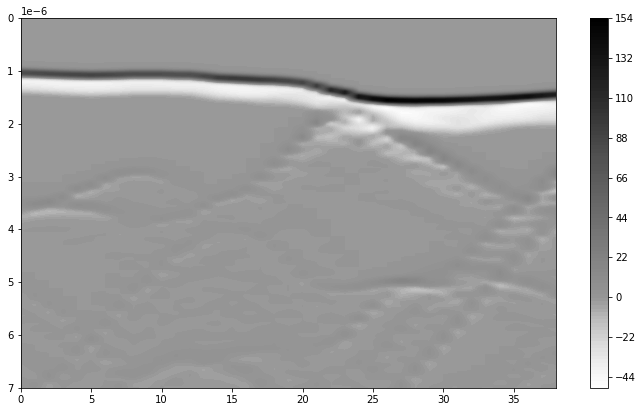

In [12]:
# Method 1 - Data generated per point not saved, radargram not saved
data = fullModel.processData('demoData/sparsePath.gpx', save = False)

100% (39 of 39) |#############################################| Time: 0:11
Settings: maxTime = 7e-06, dt = 8e-09, steps = 875
100% (39 of 39) |#############################################| Time: 0:07
saving


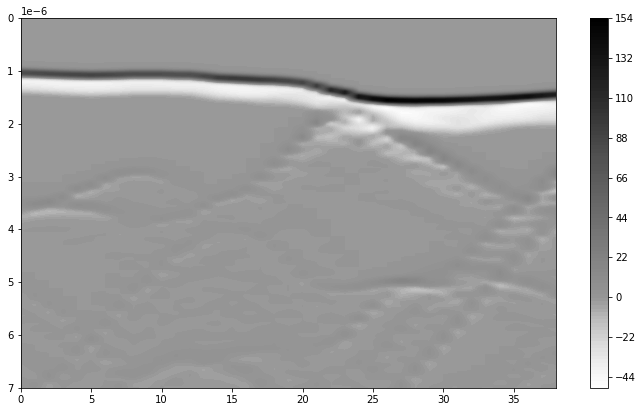

In [14]:
# Method 2 - Data generated per point is saved, radargram saved
if os.path.exists("demoData/points"):
    shutil.rmtree("demoData/points")
path.processData('demoData/sparsePath.gpx',outName = 'demoData/points')
data = radar.radargram('demoData/points',save = 'demoData/figure')

In [32]:
%%capture result # hides output of command, remove to show result.
# Method 3 - Command line
! python -m declutter model demoData/sparsePath.gpx -f -o demoData/points -s demoData/figure

## Display a radargram from existing point files

If the option was selected to store .hdf5 files for each point in the previous step ('demoData/points', created by methods 2 or 3), the radargram can now be quickly displayed.

Settings: maxTime = 7e-06, dt = 8e-09, steps = 875
100% (39 of 39) |#############################################| Time: 0:07


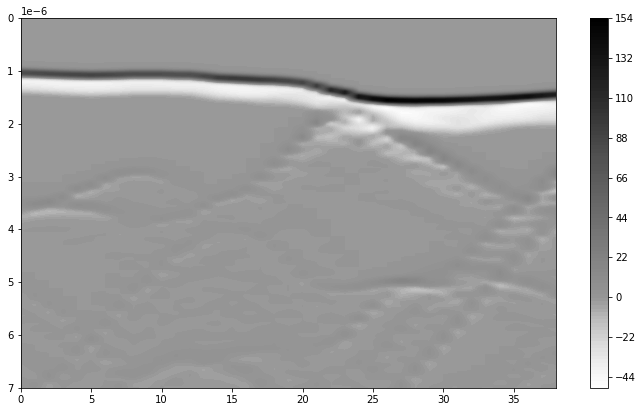

In [13]:
from declutter import radar
# Method 1
data = radar.radargram('demoData/points')

In [ ]:
%%capture result # hides output of command, remove to show result.
# Method 2
!! python -m declutter display demoData/points

## Compare the radargrams of slightly varying models

The list of options to use is defined in the compare.py module, and the approach is similar for waves, backscatter or directivity models.

Settings: maxTime = 7e-06, dt = 1e-08, steps = 700
100% (39 of 39) |#############################################| Time: 0:07
100% (39 of 39) |#############################################| Time: 0:07
100% (39 of 39) |#############################################| Time: 0:07
100% (39 of 39) |#############################################| Time: 0:07


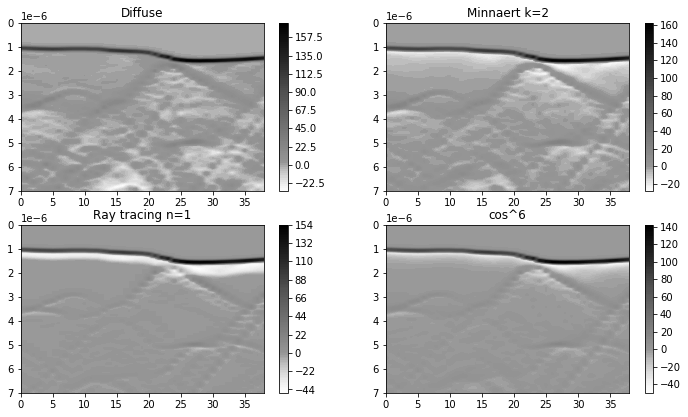

In [9]:
from declutter import compare
out = compare.compareBackscatter("demoData/points")

## Single point trace

The output of the model for a single point can also be shown.

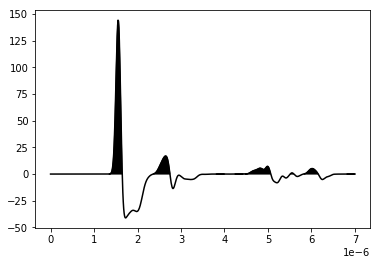

In [11]:
from declutter import radar
from declutter.modelling import backscatter
out = radar.wiggle('demoData/points/point30.hdf5')

## Find cause of peaks

The analysis model provides a 3D plot of the surrounds for a point and highlights the surfaces causing a response.

324 points in this interval
Total intensity: 86.2136714498


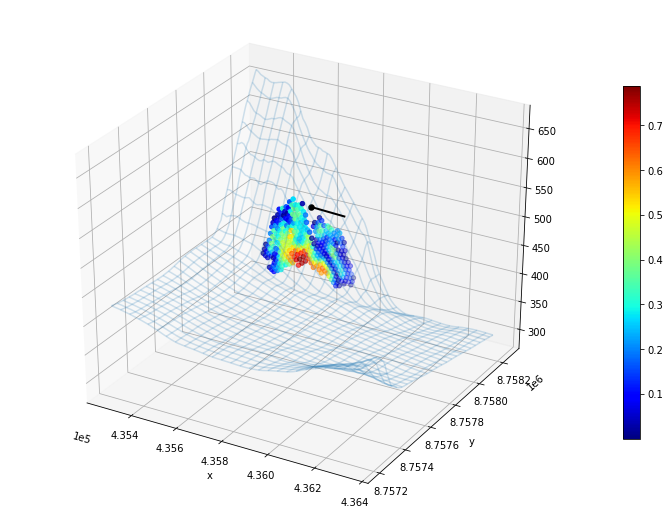

463 points in this interval
Total intensity: 98.3835063932


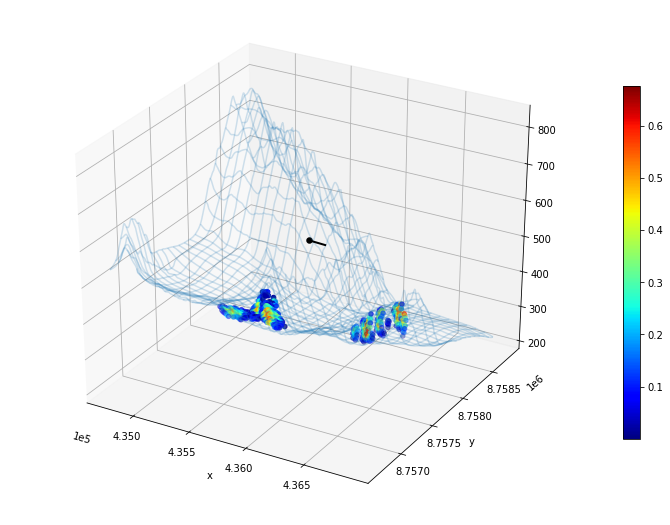

In [23]:
from declutter import analysis
analysis.markSurfaces("demoData/points/point30.hdf5",2.5e-6,3e-6)
analysis.markSurfaces("demoData/points/point30.hdf5",4.5e-6,6e-6)

## Command line help

The cell below displays the help info for each of the command line options.

In [16]:
divider = '\n\n'+'-'*80+'\n\n'
! python -m declutter -h

print divider

! python -m declutter load -h

print divider

! python -m declutter model -h

print divider

! python -m declutter display -h

print divider

! python -m declutter config -h

print divider

! python -m declutter crop -h

usage: python -m declutter [-h] {load,model,display,config,crop} ...

optional arguments:
  -h, --help            show this help message and exit

subcommands:
  Select one of the commands listed below. Use '<command> -h' to display
  help for that particular command. For more detailed instructions, see the
  gitlab page https://gitlab.data.bas.ac.uk/dboyle/radar-
  declutter/wikis/Contents

  {load,model,display,config,crop}
    load                Loads a raster into numpy arrays.
    model               Displays the radargram for a path.
    display             Displays a radargram from existing point data.
    config              Sets the range/granularity of radargrams.
    crop                Crop the maps.hdf5 file.


--------------------------------------------------------------------------------


usage: python -m declutter load [-h] [-c CELLSIZE] [-o OUT]
                                filename latitude longitude

Takes a raster and generates the slope and aspect of the surf